## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import os
import time

from random import shuffle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

## Helper Function

In [147]:
def show_images(imgs, titles=None, ncols=2):
    n = len(imgs)
    nrows = (n + ncols - 1) // ncols
    
    f, ax = plt.subplots(nrows, 2, figsize=(10, 10 * nrows))
    f.tight_layout()

    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        if i < n:
            img = imgs[i]
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img[:,:,::-1])
            if titles != None:
                ax.set_title(titles[i], fontsize=15)        
        ax.axis('off')
        
def show_image(img, title=''):
    show_images([img], [title], 1)


## 1. Data preparation

In [149]:
# load images of car and non-car
img_cars = glob.glob("data/vehicles/*/*.*")
img_nocars = glob.glob("data/non-vehicles/*/*.*")

# shuffle them
shuffle(img_cars)
shuffle(img_nocars)
im = cv2.imread(img_cars[0])

print("# of vehicles images: {}".format(len(img_cars)))
print("# of non-vehicles images: {}".format(len(img_nocars)))
print("image shape {} of type {}".format(im.shape, im.dtype))


# of vehicles images: 8792
# of non-vehicles images: 8968
image shape (64, 64, 3) of type uint8


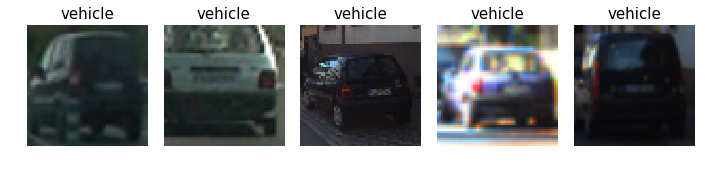

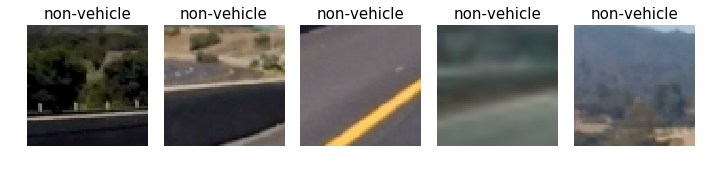

In [150]:
# display some exmaples
N = 5

# vehicles
imgs = [cv2.imread(x) for x in img_cars[:N]]
show_images(imgs[:N], ['vehicle'] * N, ncols=N)

# non-vehicles 
imgs = [cv2.imread(x) for x in img_nocars[:N]]
show_images(imgs[:N], ['non-vehicle'] * N, ncols=N)

## 2. HOG features

In [15]:
# hog function
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # two outputs (features, hog_image) if vis==True
    # otherwise with one output (features)
    return hog(img, orientations=orient, 
              pixels_per_cell=(pix_per_cell, pix_per_cell),
              cells_per_block=(cell_per_block, cell_per_block), 
              transform_sqrt=False, block_norm='L2-Hys',
              visualise=vis, feature_vector=feature_vec)

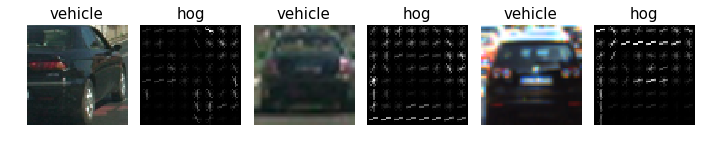

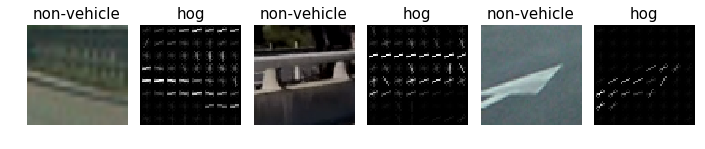

In [16]:
# draw hog of examples
orient = 9
pix_per_cell = 8
cell_per_block = 2

def show_hogs(files, label):   
    imgs = [cv2.imread(x) for x in files]
    results = []
    labels = []
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, hog_image = get_hog_features(gray, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        results += [img, hog_image]
        labels += [label, 'hog']

    show_images(results, labels, ncols=len(files) * 2)
    
show_hogs(img_cars[:3], 'vehicle')
show_hogs(img_nocars[:3], 'non-vehicle')

## 3. Color histogram features

In [17]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    bins_range=(0, 256)
    
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = ch1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

    if vis == True:
        return ch1_hist[0], ch2_hist[0], ch3_hist[0], bin_centers
    else:
        return hist_features

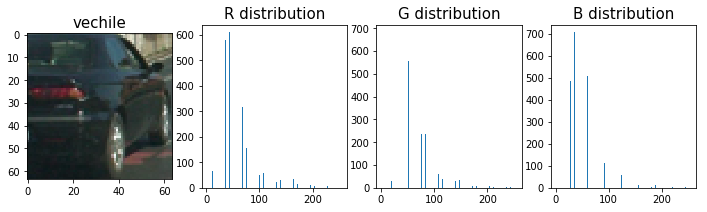

In [38]:
# draw color histgram of an example

# Read in the image
img = cv2.imread(img_cars[0])
channelB_hist, channelG_hist, channelR_hist, bin_centers = color_hist(img, vis=True)

# Plot the examples
fig = plt.subplots(1, 4, figsize=(12,3));

def plotHist(id, nplots, center, bars, label):
    plt.subplot(1, nplots, id)
    plt.bar(center, bars)
    plt.title(label, fontsize=15)

# plot vehicle
plt.subplot(1, 4, 1)
plt.imshow(img[:,:,::-1])
plt.title('vechile', fontsize=15)

# plot histograms
plotHist(2, 4, bin_centers, channelR_hist, 'R distribution')
plotHist(3, 4, bin_centers, channelG_hist, 'G distribution')
plotHist(4, 4, bin_centers, channelB_hist, 'B distribution')


## 4. Spatial Binning of Color features

In [41]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel(order='F') 

    # Return the feature vector
    return features

Text(0.5,1,'bin spatial')

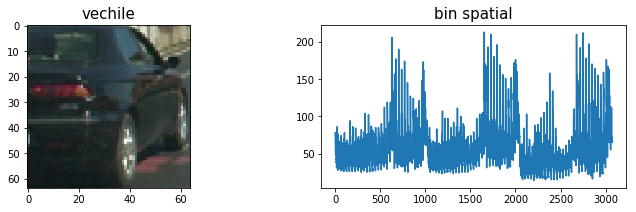

In [42]:
# Read in the image
img = cv2.imread(img_cars[0])
spatial_features = bin_spatial(img)

# Plot the examples
fig = plt.subplots(1, 2, figsize=(12,3));

# plot vehicle
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
plt.title('vechile', fontsize=15)

# plot bin spatial
plt.subplot(1, 2, 2)
plt.plot(spatial_features)
plt.title('bin spatial', fontsize=15)

## 5. Feature Extractions

In [43]:
# Define a function to extract features from a list of images
def extract_features(images, color_space='HLS', 
                     hist_bins=32, 
                     spatial_size=(32, 32),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        img_features = []
        img = cv2.imread(file) 

        # apply color conversion if other than 'BGR'
        if color_space != 'BGR':
            if color_space == 'RGB':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        # hog features
        hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
        
        # hist color features
        hist_features = color_hist(feature_image, nbins=hist_bins)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        features.append(np.concatenate((hist_features, spatial_features, hog_features)))

    # Return list of feature vectors
    return features

In [44]:
# test extract_features by examples
features = extract_features(img_cars[:3])
print('feaure length: {}'.format(len(features[0])))

feaure length: 4932


## 6. Training and testing Support Vector Classifier

In [48]:
# get features
feature_cars = extract_features(img_cars)
feature_nocars = extract_features(img_nocars)

NameError: name 'time' is not defined

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((feature_cars, feature_nocars)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(feature_cars)), np.zeros(len(feature_nocars))))

In [ ]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=1234)

In [50]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
elapse = time.time() - t
print('SVC took {:.2f} seconds to train {} samples.'.format(elapse, len(y_train)))

Training SVC took 15.01 seconds for 14208 training samples.


In [52]:
# test accuracy
score = svc.score(X_test, y_test)
print('Test Accuracy: {:.2f}%'.format(score*100))
print('  Predictions: {}'.format(svc.predict(X_test[0:10])))
print('       Labels: {}'.format(y_test[0:10]))

Test Accuracy: 97.18%
  Predictions: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
       Labels: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]


## 7. Classification using CNN (EXTRA WORKS)
We can use CNN to do classification.  It is easier, faster and more accurate. 

In [105]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D

def create_model():
    '''
        to create nVidia car self-driving model
    '''
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(64, 64,3)))
    model.add(Conv2D(24, (3,3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, (3,3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (3,3), activation='relu'))

    model.add(Flatten())
    model.add(Dense(80, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 24)        672       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 36)        7812      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 48)        15600     
_________________________________________________________________
flatten_5 (Flatten)          (None, 8112)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 80)                649040    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                810       
__________

In [106]:
# prepase it and train it
sample_X = []
sample_y = []
for file in img_cars:
    im = cv2.imread(file)
    sample_X.append(im)
    sample_y.append(1)
for file in img_nocars:
    im = cv2.imread(file)
    sample_X.append(im)
    sample_y.append(0)

X_train, X_test, y_train, y_test = train_test_split(sample_X, sample_y,
                                                    test_size=0.2,
                                                    random_state=1234)

# data argument: add X_train, y_train by mirror
for x, y in list(zip(X_train, y_train)):
    X_train.append(x[:,::-1,:])   # mirror image
    y_train.append(y)

X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

In [107]:
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=32)
print('')
print('Test Accuracy by CNN: {:.2f}%'.format(score[1]*100))

Train on 28416 samples, validate on 3552 samples
Epoch 1/5
28416/28416 [==============================] - 9s 303us/step - loss: 0.1320 - acc: 0.9474 - val_loss: 0.0574 - val_acc: 0.9780
Epoch 2/5
28416/28416 [==============================] - 9s 301us/step - loss: 0.0432 - acc: 0.9852 - val_loss: 0.0373 - val_acc: 0.9848
Epoch 3/5
28416/28416 [==============================] - 8s 299us/step - loss: 0.0323 - acc: 0.9891 - val_loss: 0.0176 - val_acc: 0.9947
Epoch 4/5
28416/28416 [==============================] - 8s 295us/step - loss: 0.0245 - acc: 0.9917 - val_loss: 0.0184 - val_acc: 0.9941
Epoch 5/5
3552/3552 [==============================] - 0s 123us/step
Test Accuracy by CNN: 99.47%


## 8. Sliding Window Implementation

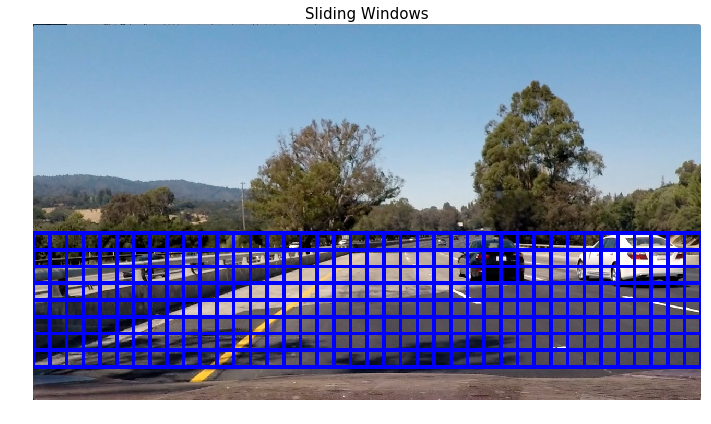

In [151]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img = cv2.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows)
show_image(window_img, 'Sliding Windows')
